In [2]:
!pip install torch torchvision matplotlib --quiet

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)


100%|██████████| 170M/170M [00:14<00:00, 12.1MB/s]


In [6]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 3*32*32),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(z.size(0), 3, 32, 32)
        return img


In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(3*32*32, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        return self.model(img_flat)


In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

latent_dim = 100

generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

criterion = nn.BCELoss()

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)


In [9]:
epochs = 50  # increase to 100–300 for much better results

for epoch in range(epochs):
    for i, (imgs, _) in enumerate(dataloader):

        imgs = imgs.to(device)
        batch_size = imgs.size(0)

        # Real and fake labels
        real = torch.ones(batch_size, 1).to(device)
        fake = torch.zeros(batch_size, 1).to(device)

        # -------------------------
        # Train Discriminator
        # -------------------------
        optimizer_D.zero_grad()

        # 1. real images
        real_loss = criterion(discriminator(imgs), real)

        # 2. fake images
        z = torch.randn(batch_size, latent_dim).to(device)
        gen_imgs = generator(z)
        fake_loss = criterion(discriminator(gen_imgs.detach()), fake)

        # total discriminator loss
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # -------------------------
        # Train Generator
        # -------------------------
        optimizer_G.zero_grad()

        # wants discriminator to classify fake as real
        g_loss = criterion(discriminator(gen_imgs), real)

        g_loss.backward()
        optimizer_G.step()

        if i % 200 == 0:
            print(f"Epoch {epoch+1}/{epochs} | Batch {i} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")


Epoch 1/50 | Batch 0 | D Loss: 1.3980 | G Loss: 0.6932
Epoch 1/50 | Batch 200 | D Loss: 0.7812 | G Loss: 0.8923
Epoch 2/50 | Batch 0 | D Loss: 3.0714 | G Loss: 1.7736
Epoch 2/50 | Batch 200 | D Loss: 0.0637 | G Loss: 4.8820
Epoch 3/50 | Batch 0 | D Loss: 0.0339 | G Loss: 6.3334
Epoch 3/50 | Batch 200 | D Loss: 0.0235 | G Loss: 5.7350
Epoch 4/50 | Batch 0 | D Loss: 0.0048 | G Loss: 8.0997
Epoch 4/50 | Batch 200 | D Loss: 0.0052 | G Loss: 8.7365
Epoch 5/50 | Batch 0 | D Loss: 0.0032 | G Loss: 9.6980
Epoch 5/50 | Batch 200 | D Loss: 0.0013 | G Loss: 10.4196
Epoch 6/50 | Batch 0 | D Loss: 0.0009 | G Loss: 10.7321
Epoch 6/50 | Batch 200 | D Loss: 0.0014 | G Loss: 9.5747
Epoch 7/50 | Batch 0 | D Loss: 0.0035 | G Loss: 8.3903
Epoch 7/50 | Batch 200 | D Loss: 0.0039 | G Loss: 9.0676
Epoch 8/50 | Batch 0 | D Loss: 0.0010 | G Loss: 10.2674
Epoch 8/50 | Batch 200 | D Loss: 0.0008 | G Loss: 10.8527
Epoch 9/50 | Batch 0 | D Loss: 0.0006 | G Loss: 11.5555
Epoch 9/50 | Batch 200 | D Loss: 0.0005 | G 

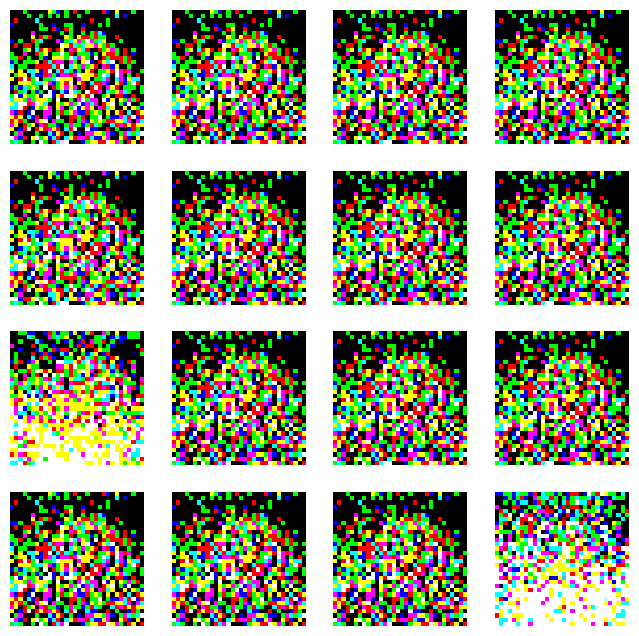

In [10]:
def show_images(images):
    images = images / 2 + 0.5
    np_images = images.cpu().detach().numpy()
    plt.figure(figsize=(8,8))
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.imshow(np.transpose(np_images[i], (1,2,0)))
        plt.axis("off")
    plt.show()

# Generate samples
z = torch.randn(16, latent_dim).to(device)
gen_imgs = generator(z)
show_images(gen_imgs)
